In [2]:
# ============================================================
# FASHION-MNIST CNN CLASSIFICATION - GOOGLE COLAB (GPU READY)
# ============================================================

# ── STEP 0: Verify GPU ──────────────────────────────────────
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ── STEP 1: Import Libraries ────────────────────────────────
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

print("\n✅ All libraries imported successfully!")

# ── STEP 2: Define Class Labels ─────────────────────────────
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
print(f"\n📦 Classes ({len(class_names)} total):")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

# ── STEP 3: Data Transforms ─────────────────────────────────
# Training: augmentation for better generalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # mean=0.5, std=0.5
])

# Testing: only normalize (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("\n✅ Transforms defined!")
print("  Train: RandomHorizontalFlip + RandomRotation + Normalize")
print("  Test : Normalize only")

PyTorch version: 2.10.0+cu128
CUDA available: True
Using device: cuda
GPU: Tesla T4

✅ All libraries imported successfully!

📦 Classes (10 total):
  0: T-shirt/top
  1: Trouser
  2: Pullover
  3: Dress
  4: Coat
  5: Sandal
  6: Shirt
  7: Sneaker
  8: Bag
  9: Ankle boot

✅ Transforms defined!
  Train: RandomHorizontalFlip + RandomRotation + Normalize
  Test : Normalize only


In [3]:

# ── STEP 4: Load Fashion-MNIST Dataset ──────────────────────
print("\n⬇️  Downloading Fashion-MNIST dataset...")

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=test_transform
)

# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"\n✅ Dataset loaded!")
print(f"  Training samples : {len(train_dataset):,}")
print(f"  Test samples     : {len(test_dataset):,}")
print(f"  Batch size       : {BATCH_SIZE}")
print(f"  Training batches : {len(train_loader)}")
print(f"  Test batches     : {len(test_loader)}")



⬇️  Downloading Fashion-MNIST dataset...


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.82MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.5MB/s]


✅ Dataset loaded!
  Training samples : 60,000
  Test samples     : 10,000
  Batch size       : 64
  Training batches : 938
  Test batches     : 157


# **Fashion MNIST Classification**

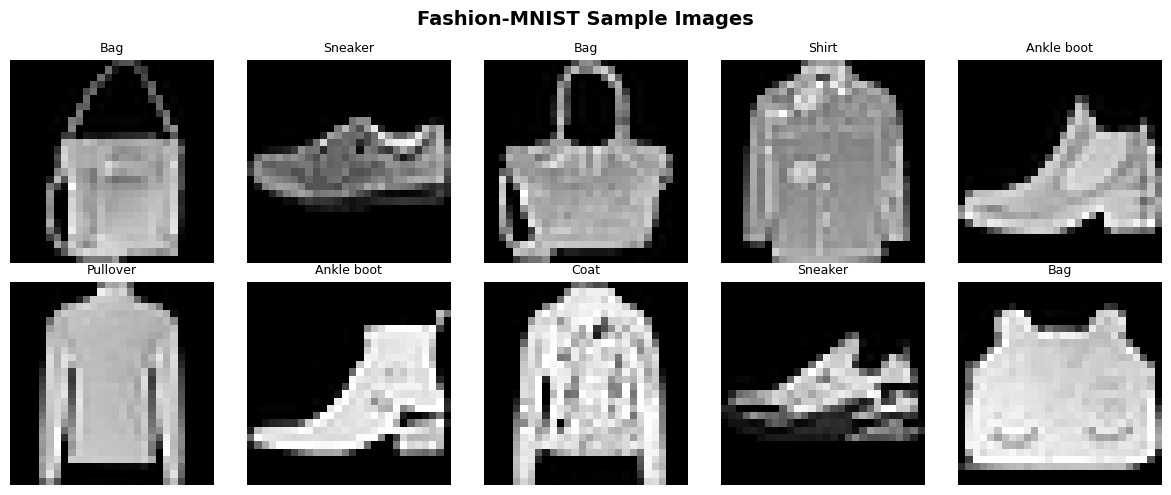

In [4]:
# ── STEP 5: Visualize Sample Images ─────────────────────────
def show_samples(dataset, class_names, n=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle("Fashion-MNIST Sample Images", fontsize=14, fontweight='bold')
    indices = np.random.choice(len(dataset), n, replace=False)
    for i, ax in enumerate(axes.flat):
        img, label = dataset[indices[i]]
        img = img.squeeze().numpy() * 0.5 + 0.5  # denormalize
        ax.imshow(img, cmap='gray')
        ax.set_title(class_names[label], fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Use raw test dataset (no augmentation) for visualization
raw_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=False,
    transform=transforms.ToTensor()
)
show_samples(raw_test, class_names)

In [6]:


# ── STEP 6: Define the CNN Architecture ─────────────────────
class FashionCNN(nn.Module):
    """
    CNN Architecture:
    ┌─────────────────────────────────┐
    │ Input: 1×28×28                  │
    ├─────────────────────────────────┤
    │ Conv Block 1: 32 filters, 3×3   │
    │ BatchNorm → ReLU → MaxPool(2×2) │  → 32×14×14
    ├─────────────────────────────────┤
    │ Conv Block 2: 64 filters, 3×3   │
    │ BatchNorm → ReLU → MaxPool(2×2) │  → 64×7×7
    ├─────────────────────────────────┤
    │ Conv Block 3: 128 filters, 3×3  │
    │ BatchNorm → ReLU → MaxPool(2×2) │  → 128×3×3
    ├─────────────────────────────────┤
    │ Flatten → FC(1152→256) → Drop   │
    │ FC(256→128) → Drop              │
    │ FC(128→10)  ← output            │
    └─────────────────────────────────┘
    """
    def __init__(self):
        super(FashionCNN, self).__init__()

        # ── Convolutional Block 1 ──
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # 1×28×28 → 32×28×28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 32×28×28 → 32×28×28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                            # → 32×14×14
            nn.Dropout2d(0.25)
        )

        # ── Convolutional Block 2 ──
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # → 64×14×14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # → 64×14×14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                            # → 64×7×7
            nn.Dropout2d(0.25)
        )

        # ── Convolutional Block 3 ──
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # → 128×7×7
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                            # → 128×3×3
            nn.Dropout2d(0.25)
        )

        # ── Fully Connected Head ──
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 10)                            # 10 classes
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

# Instantiate and move to device
model = FashionCNN().to(device)
print("\n✅ Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable    = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total parameters    : {total_params:,}")
print(f"   Trainable parameters: {trainable:,}")

# ── STEP 7: Loss, Optimizer & Scheduler ─────────────────────
LEARNING_RATE = 0.001
NUM_EPOCHS    = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

print(f"\n✅ Training setup:")
print(f"  Loss function : CrossEntropyLoss")
print(f"  Optimizer     : Adam (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"  Scheduler     : ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"  Epochs        : {NUM_EPOCHS}")

# ── STEP 8: Training & Validation Functions ─────────────────
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    return running_loss / total, 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)
    return running_loss / total, 100. * correct / total

print("\n✅ Training and evaluation functions defined!")



✅ Model Architecture:
FashionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): M

In [7]:
# ── STEP 9: Training Loop ───────────────────────────────────
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_state = None

print(f"\n🚀 Starting training on {device}...\n")
print(f"{'Epoch':>5} {'Train Loss':>11} {'Train Acc':>10} {'Val Loss':>10} {'Val Acc':>9} {'Time':>7}")
print("─" * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = evaluate(model, test_loader, criterion, device)

    scheduler.step(val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    elapsed = time.time() - t0
    print(f"{epoch:>5} {train_loss:>11.4f} {train_acc:>9.2f}% {val_loss:>10.4f} {val_acc:>8.2f}% {elapsed:>6.1f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        print(f"        ⭐ New best model saved! Val Acc: {best_val_acc:.2f}%")

print(f"\n✅ Training complete! Best Validation Accuracy: {best_val_acc:.2f}%")





🚀 Starting training on cuda...

Epoch  Train Loss  Train Acc   Val Loss   Val Acc    Time
────────────────────────────────────────────────────────────
    1      0.6764     75.22%     0.4171    84.50%   24.6s
        ⭐ New best model saved! Val Acc: 84.50%
    2      0.4510     83.82%     0.3531    86.69%   23.7s
        ⭐ New best model saved! Val Acc: 86.69%
    3      0.3908     85.83%     0.3222    88.38%   22.8s
        ⭐ New best model saved! Val Acc: 88.38%
    4      0.3625     87.13%     0.2885    89.64%   24.1s
        ⭐ New best model saved! Val Acc: 89.64%
    5      0.3448     87.71%     0.2837    89.55%   23.3s
    6      0.3295     88.36%     0.2658    89.98%   23.4s
        ⭐ New best model saved! Val Acc: 89.98%
    7      0.3184     88.78%     0.2764    89.63%   23.3s
    8      0.3099     89.01%     0.2583    90.62%   23.3s
        ⭐ New best model saved! Val Acc: 90.62%
    9      0.3016     89.30%     0.2439    91.14%   23.2s
        ⭐ New best model saved! Val Ac

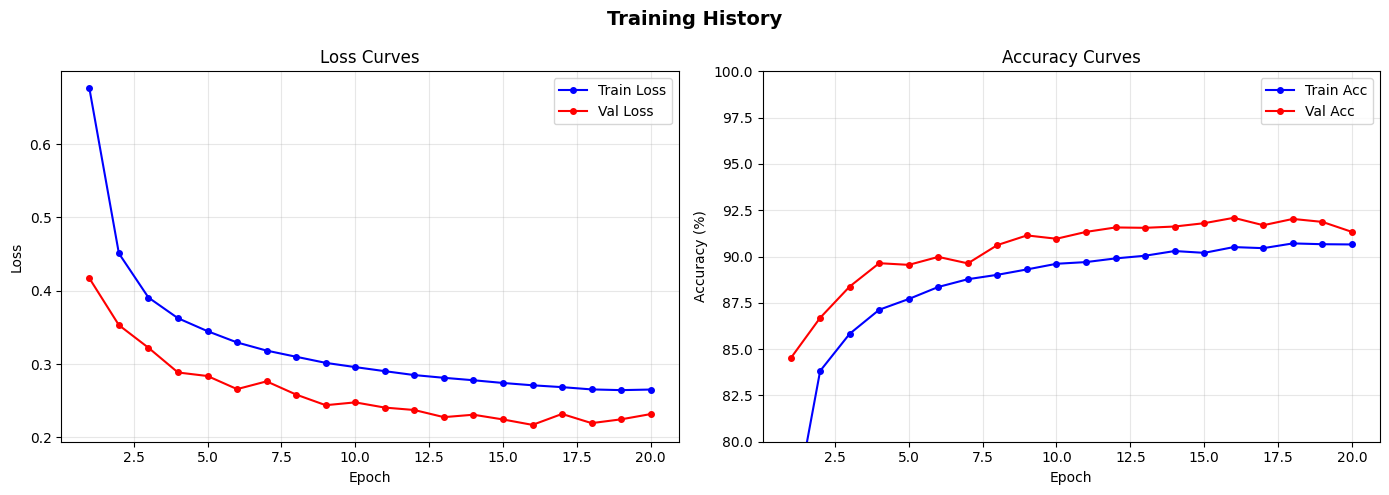

In [8]:
# ── STEP 10: Plot Training Curves ───────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Training History", fontsize=14, fontweight='bold')
epochs = range(1, NUM_EPOCHS + 1)

ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', markersize=4)
ax1.plot(epochs, history['val_loss'],   'r-o', label='Val Loss',   markersize=4)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves'); ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', markersize=4)
ax2.plot(epochs, history['val_acc'],   'r-o', label='Val Acc',   markersize=4)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curves'); ax2.legend(); ax2.grid(True, alpha=0.3)
ax2.set_ylim([80, 100])

plt.tight_layout()
plt.show()


In [9]:

# ── STEP 11: Load Best Model & Final Evaluation ─────────────
model.load_state_dict(best_model_state)
final_loss, final_acc = evaluate(model, test_loader, criterion, device)
print(f"\n📊 Final Test Accuracy (best model): {final_acc:.2f}%")
print(f"   Final Test Loss                 : {final_loss:.4f}")



📊 Final Test Accuracy (best model): 92.09%
   Final Test Loss                 : 0.2170



📋 Generating Classification Report...

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.88      0.90      0.89      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.86      0.91      0.89      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.80      0.73      0.76      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



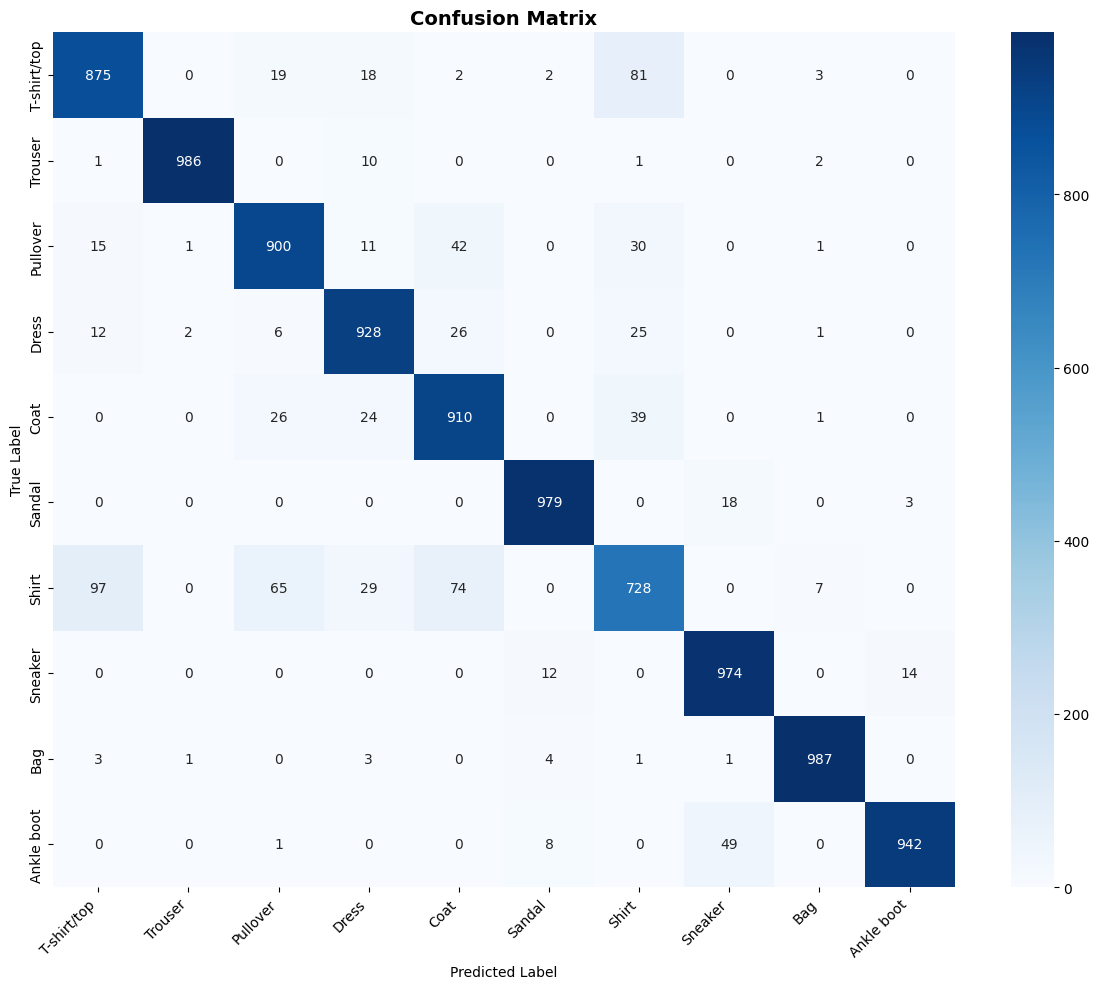

In [10]:
# ── STEP 12: Classification Report ─────────────────────────
print("\n📋 Generating Classification Report...")
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n" + classification_report(all_labels, all_preds, target_names=class_names))

# ── STEP 13: Confusion Matrix ───────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



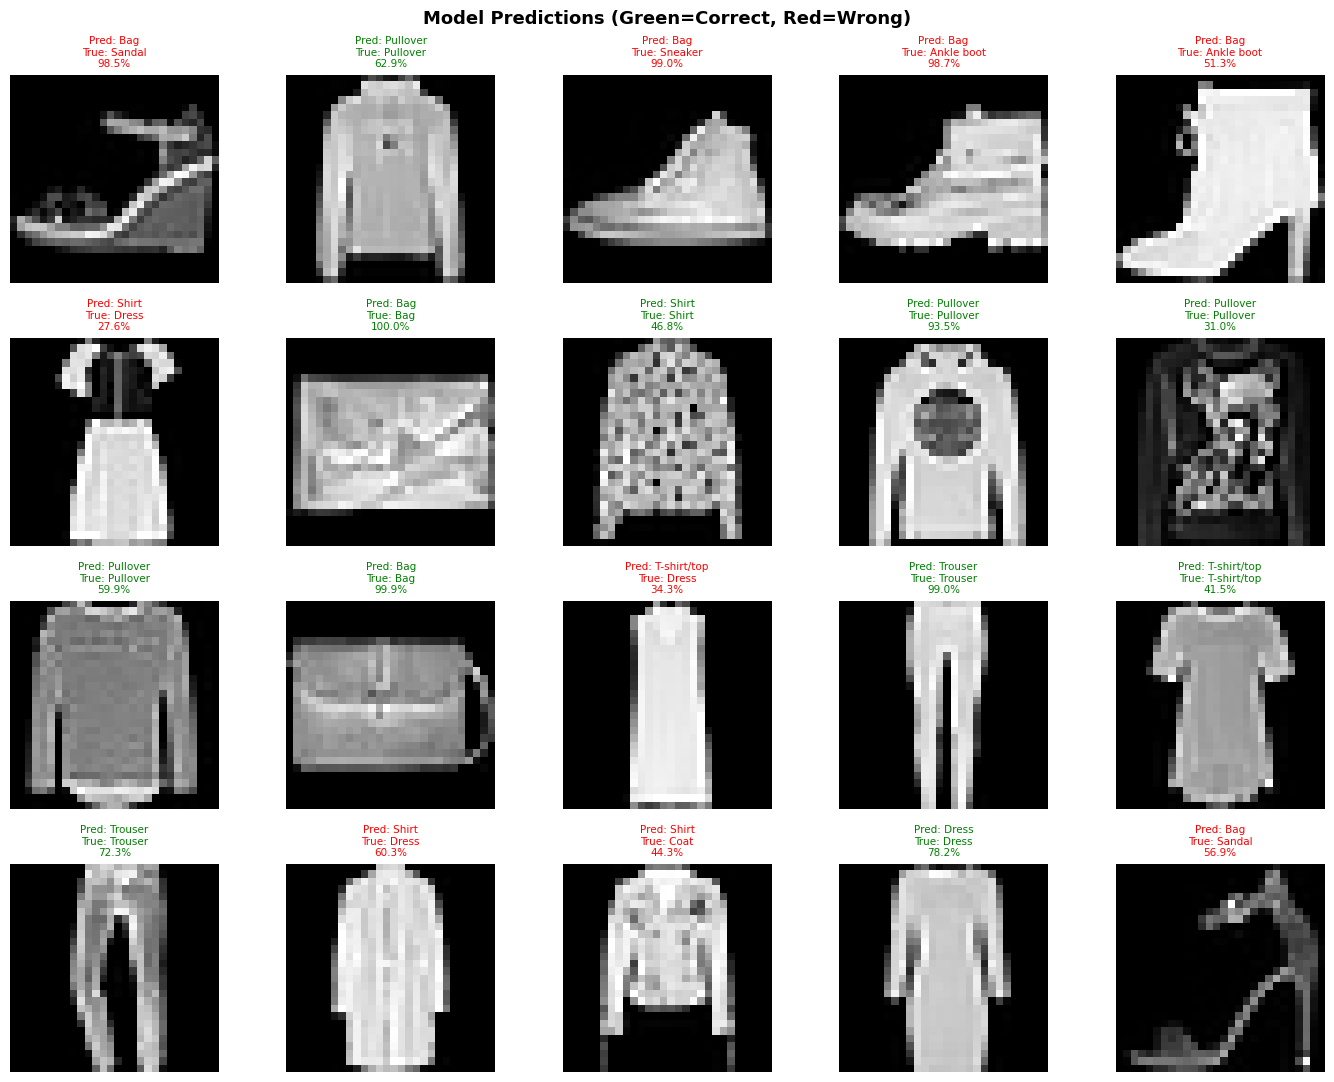

In [11]:
# ── STEP 14: Visualize Predictions ──────────────────────────
def show_predictions(model, dataset, class_names, n=20, device='cpu'):
    model.eval()
    indices = np.random.choice(len(dataset), n, replace=False)
    fig, axes = plt.subplots(4, 5, figsize=(14, 11))
    fig.suptitle("Model Predictions (Green=Correct, Red=Wrong)", fontsize=13, fontweight='bold')

    with torch.no_grad():
        for i, ax in enumerate(axes.flat):
            img, true_label = dataset[indices[i]]
            output = model(img.unsqueeze(0).to(device))
            pred_label = output.argmax(1).item()
            conf = torch.softmax(output, dim=1).max().item() * 100

            img_np = img.squeeze().numpy() * 0.5 + 0.5
            ax.imshow(img_np, cmap='gray')
            color = 'green' if pred_label == true_label else 'red'
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}\n{conf:.1f}%",
                color=color, fontsize=7.5
            )
            ax.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(model, raw_test, class_names, n=20, device=device)




📊 Per-Class Accuracy:

Class             Accuracy
───────────────────────────
T-shirt/top         87.5%  █████████████████
Trouser             98.6%  ███████████████████
Pullover            90.0%  ██████████████████
Dress               92.8%  ██████████████████
Coat                91.0%  ██████████████████
Sandal              97.9%  ███████████████████
Shirt               72.8%  ██████████████
Sneaker             97.4%  ███████████████████
Bag                 98.7%  ███████████████████
Ankle boot          94.2%  ██████████████████


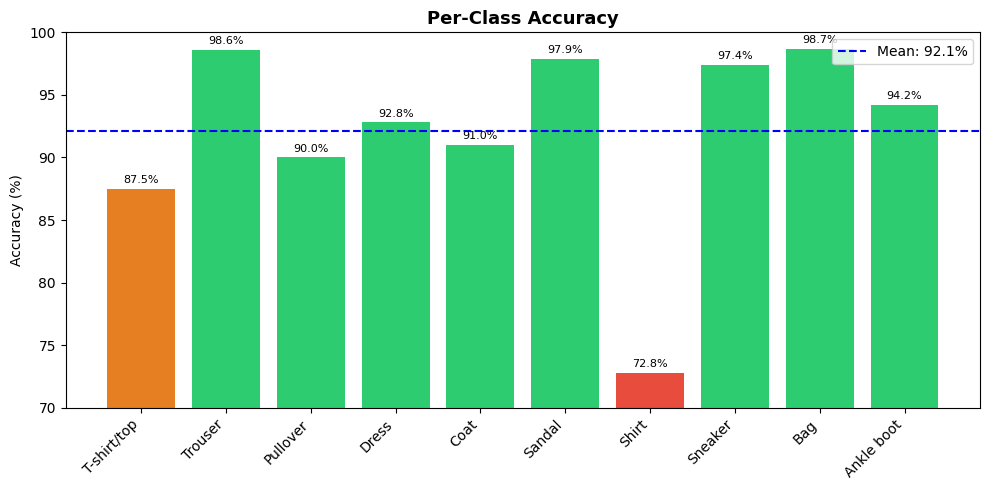

In [12]:
# ── STEP 15: Per-Class Accuracy ─────────────────────────────
print("\n📊 Per-Class Accuracy:")
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
per_class_acc = cm_norm.diagonal() * 100
print(f"\n{'Class':<15} {'Accuracy':>10}")
print("─" * 27)
for name, acc in zip(class_names, per_class_acc):
    bar = '█' * int(acc / 5)
    print(f"{name:<15} {acc:>8.1f}%  {bar}")

# Bar chart
plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if a >= 90 else '#e67e22' if a >= 80 else '#e74c3c' for a in per_class_acc]
bars = plt.bar(class_names, per_class_acc, color=colors)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy (%)'); plt.ylim([70, 100])
plt.title('Per-Class Accuracy', fontsize=13, fontweight='bold')
plt.axhline(y=np.mean(per_class_acc), color='blue', linestyle='--',
            label=f'Mean: {np.mean(per_class_acc):.1f}%')
for bar, acc in zip(bars, per_class_acc):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=8)
plt.legend(); plt.tight_layout(); plt.show()



In [13]:
# ── STEP 16: Save Model ─────────────────────────────────────
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'class_names': class_names,
    'architecture': 'FashionCNN'
}, 'fashion_mnist_cnn_best.pth')

print("\n✅ Model saved as 'fashion_mnist_cnn_best.pth'")
print(f"\n{'='*50}")
print(f"  🎉 FINAL RESULTS SUMMARY")
print(f"{'='*50}")
print(f"  Best Validation Accuracy : {best_val_acc:.2f}%")
print(f"  Final Test Accuracy      : {final_acc:.2f}%")
print(f"  Final Test Loss          : {final_loss:.4f}")
print(f"  Device Used              : {device}")
print(f"  Total Parameters         : {trainable:,}")
print(f"{'='*50}")


✅ Model saved as 'fashion_mnist_cnn_best.pth'

  🎉 FINAL RESULTS SUMMARY
  Best Validation Accuracy : 92.09%
  Final Test Accuracy      : 92.09%
  Final Test Loss          : 0.2170
  Device Used              : cuda
  Total Parameters         : 468,842
